In [3]:
## Python
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')


## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical

from keras.models import Model, Sequential
from keras import optimizers
from keras.layers import Input, Conv1D, Conv2D,BatchNormalization, MaxPooling1D,MaxPooling2D, LSTM, Dense, Activation, Layer,Reshape

from keras.utils import to_categorical
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm_notebook as tqdm

input_duration=3
# % pylab inline

Using TensorFlow backend.


### RAVDESS DATASET

In [4]:
# Data Directory
# Please edit according to your directory change.
Ravdess_paths= np.array(("E:/NYU_Classes/Project/Ravdess_Audio_Speech_Actors_01-24/","E:/NYU_Classes/Project/Ravdess_Audio_Song_Actors_01-24/"))
dir_list = os.listdir(Ravdess_paths[0])
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [5]:
# Create DataFrame for Data intel
ravdess_db = pd.DataFrame(columns=['path','source','actor', 'gender', 'emotion','emotion_lb'])
count = 0
for data_path in Ravdess_paths:
    dir_list = os.listdir(data_path)
    dir_list.sort()
    for i in dir_list:
        file_list = os.listdir(data_path + i)
        for f in file_list:
            nm = f.split('.')[0].split('-')
            path = data_path + i + '/' + f
            src = int(nm[1])
            actor = int(nm[-1])
            emotion = int(nm[2])
            source = "Ravdess"

            if int(actor)%2 == 0:
                gender = "female"
            else:
                gender = "male"

            if nm[3] == '01':
                intensity = 0
            else:
                intensity = 1

            if nm[4] == '01':
                statement = 0
            else:
                statement = 1

            if nm[5] == '01':
                repeat = 0
            else:
                repeat = 1

            if emotion == 1:
                lb = "neutral"
            elif emotion == 2:
                lb = "calm"
            elif emotion == 3:
                lb = "happy"
            elif emotion == 4:
                lb = "sad"
            elif emotion == 5:
                lb = "angry"
            elif emotion == 6:
                lb = "fearful"
            elif emotion == 7:
                lb = "disgust"
            elif emotion == 8:
                lb = "surprised"
            else:
                lb = "none"

            ravdess_db.loc[count] = [path,source,actor, gender, emotion,lb]
            count += 1

In [6]:
ravdess_db.head()

path   source actor gender  \
0  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess     1   male   
1  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess     1   male   
2  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess     1   male   
3  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess     1   male   
4  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess     1   male   

  emotion emotion_lb  
0       1    neutral  
1       1    neutral  
2       1    neutral  
3       1    neutral  
4       2       calm

In [7]:
ravdess_db['split'] =  np.where((ravdess_db.actor ==23) | (ravdess_db.actor ==24), 'Test', 
                                (np.where((ravdess_db.actor ==21) | (ravdess_db.actor ==22),'Val','Train')))

In [8]:
ravdess_db['split'].value_counts()

Train    2036
Val       208
Test      208
Name: split, dtype: int64

In [9]:
ravdess_db.shape

(2452, 7)

In [ ]:
ravdess_db.emotion_lb.value_counts()

#### Changing Calm to Neutral and Removing Surprised to Make it into 6 classs prediction

In [8]:
ravdess_db.drop(ravdess_db.index[ravdess_db['emotion_lb'] == 'surprised'], inplace = True)
ravdess_db.loc[ravdess_db.emotion_lb=='calm',['emotion','emotion_lb']]= 1,'neutral'

In [9]:
ravdess_db.emotion_lb.value_counts()

neutral    564
happy      376
angry      376
fearful    376
sad        376
disgust    192
Name: emotion_lb, dtype: int64

In [11]:
dataset_db = ravdess_db

In [12]:
dataset_db.emotion_lb = dataset_db.gender+"_"+dataset_db.emotion_lb

In [13]:
dataset_db.head()

path   source actor gender  \
0  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess     1   male   
1  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess     1   male   
2  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess     1   male   
3  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess     1   male   
4  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess     1   male   

  emotion    emotion_lb  split  
0       1  male_neutral  Train  
1       1  male_neutral  Train  
2       1  male_neutral  Train  
3       1  male_neutral  Train  
4       1  male_neutral  Train

In [14]:
dataset_db.emotion_lb.value_counts()

male_neutral      288
female_neutral    276
male_happy        192
male_sad          192
male_angry        192
male_fearful      192
female_fearful    184
female_sad        184
female_angry      184
female_happy      184
female_disgust     96
male_disgust       96
Name: emotion_lb, dtype: int64

In [15]:
modelling_db = dataset_db[(dataset_db.split=='Train') | (dataset_db.split =='Val')]

In [17]:
modelling_db.index = range(len(modelling_db.index))

In [21]:
audio_duration = 3
sampling_rate = 44100
input_length = sampling_rate * audio_duration
n_mfcc = 20


In [29]:
data_sample= np.zeros(input_length)
MFCC = librosa.feature.mfcc(data_sample, sr=sampling_rate, n_mfcc=n_mfcc)

In [31]:
modelling_db.split.value_counts()

Train    1876
Val       192
Name: split, dtype: int64

In [33]:
audios= np.empty(shape=(modelling_db.shape[0],128, MFCC.shape[1], 1))

count=0
for i in tqdm(range(len(modelling_db))):
    signal, sample_rate = librosa.load(modelling_db.path[i], res_type='kaiser_fast',sr=22050*2)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)
    
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)   
    logspec = librosa.amplitude_to_db(melspec)
    logspec = np.expand_dims(logspec, axis=-1)
    audios[count,] = logspec 
    count+=1

In [34]:
audios.shape

(2068, 128, 259, 1)

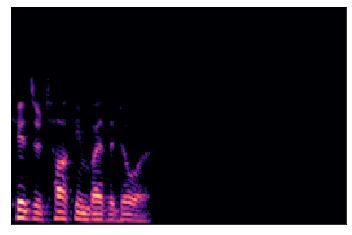

In [35]:
librosa.display.specshow(audios[0].reshape(128,259))

In [36]:
x_train = audios[(modelling_db['split'] == 'Train')]
y_train = modelling_db.emotion_lb[(modelling_db['split'] == 'Train')]

print(x_train.shape,y_train.shape)

(1876, 128, 259, 1) (1876,)


In [37]:
x_test = audios[(modelling_db['split'] == 'Val')]
y_test = modelling_db.emotion_lb[(modelling_db['split'] == 'Val')]

print(x_test.shape,y_test.shape)

(192, 128, 259, 1) (192,)


In [38]:
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

In [39]:
x_traincnn = x_train
x_testcnn = x_test

In [40]:
x_traincnn.shape,x_testcnn.shape,y_train.shape,y_test.shape

((1876, 128, 259, 1), (192, 128, 259, 1), (1876, 12), (192, 12))

In [41]:
# CNN I/P Config
num_classes = len(np.unique(np.argmax(y_train, 1)))
input_shape = x_traincnn.shape[1:]
learning_rate = 0.0001
decay = 1e-6
momentum = 0.9



In [111]:
model = Sequential(name='Audio_CNN_2D')

# LFLB1
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', data_format='channels_last',input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(BatchNormalization())
model.add(Activation('elu'))
model.add(MaxPooling2D(pool_size=(4,4), strides=(4,4)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(units=num_classes, activation='softmax'))

# Model compilation
opt = optimizers.SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [112]:
model.summary()

Model: "Audio_CNN_2D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 128, 259, 64)      640       
_________________________________________________________________
batch_normalization_32 (Batc (None, 128, 259, 64)      256       
_________________________________________________________________
activation_32 (Activation)   (None, 128, 259, 64)      0         
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 64, 129, 64)       0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 129, 64)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 64, 129, 64)       36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 64, 129, 64)      

In [113]:
#Train Config

batch_size = 16
num_epochs = 50

# Model Training
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('E:/NYU_Classes/Project/References/emotion_recognition_cnn/model/Modelfull_2_1.h5', save_best_only=True, monitor='val_categorical_accuracy', mode='max')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=batch_size, epochs=num_epochs,validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])


Train on 1876 samples, validate on 192 samples
Epoch 1/50
1876/1876 [==============================] - ETA: 1:20 - loss: 4.7121 - categorical_accuracy: 0.12 - ETA: 45s - loss: 5.4852 - categorical_accuracy: 0.0625 - ETA: 33s - loss: 4.7998 - categorical_accuracy: 0.083 - ETA: 27s - loss: 4.6913 - categorical_accuracy: 0.109 - ETA: 24s - loss: 4.4705 - categorical_accuracy: 0.125 - ETA: 21s - loss: 4.4272 - categorical_accuracy: 0.125 - ETA: 19s - loss: 4.5873 - categorical_accuracy: 0.125 - ETA: 18s - loss: 4.6812 - categorical_accuracy: 0.125 - ETA: 17s - loss: 4.6689 - categorical_accuracy: 0.111 - ETA: 16s - loss: 4.6392 - categorical_accuracy: 0.125 - ETA: 15s - loss: 4.5707 - categorical_accuracy: 0.119 - ETA: 15s - loss: 4.4883 - categorical_accuracy: 0.130 - ETA: 14s - loss: 4.4689 - categorical_accuracy: 0.120 - ETA: 14s - loss: 4.4236 - categorical_accuracy: 0.120 - ETA: 13s - loss: 4.3707 - categorical_accuracy: 0.125 - ETA: 13s - loss: 4.3085 - categorical_accuracy: 0.121 - 

1876/1876 [==============================] - ETA: 10s - loss: 1.8853 - categorical_accuracy: 0.437 - ETA: 10s - loss: 1.9397 - categorical_accuracy: 0.312 - ETA: 10s - loss: 2.0642 - categorical_accuracy: 0.375 - ETA: 10s - loss: 2.0200 - categorical_accuracy: 0.375 - ETA: 10s - loss: 2.2761 - categorical_accuracy: 0.325 - ETA: 10s - loss: 2.1572 - categorical_accuracy: 0.333 - ETA: 10s - loss: 2.0194 - categorical_accuracy: 0.357 - ETA: 10s - loss: 2.0416 - categorical_accuracy: 0.351 - ETA: 10s - loss: 2.1220 - categorical_accuracy: 0.361 - ETA: 10s - loss: 2.0644 - categorical_accuracy: 0.381 - ETA: 10s - loss: 2.0416 - categorical_accuracy: 0.386 - ETA: 9s - loss: 2.0840 - categorical_accuracy: 0.385 - ETA: 9s - loss: 2.1091 - categorical_accuracy: 0.39 - ETA: 9s - loss: 2.1100 - categorical_accuracy: 0.39 - ETA: 9s - loss: 2.1144 - categorical_accuracy: 0.39 - ETA: 9s - loss: 2.1036 - categorical_accuracy: 0.39 - ETA: 9s - loss: 2.1186 - categorical_accuracy: 0.38 - ETA: 9s - loss

1876/1876 [==============================] - ETA: 10s - loss: 1.3328 - categorical_accuracy: 0.437 - ETA: 10s - loss: 1.7103 - categorical_accuracy: 0.437 - ETA: 10s - loss: 1.5642 - categorical_accuracy: 0.479 - ETA: 10s - loss: 1.5570 - categorical_accuracy: 0.453 - ETA: 10s - loss: 1.5324 - categorical_accuracy: 0.462 - ETA: 10s - loss: 1.5723 - categorical_accuracy: 0.447 - ETA: 10s - loss: 1.5086 - categorical_accuracy: 0.473 - ETA: 10s - loss: 1.5450 - categorical_accuracy: 0.468 - ETA: 10s - loss: 1.5519 - categorical_accuracy: 0.465 - ETA: 10s - loss: 1.5719 - categorical_accuracy: 0.456 - ETA: 10s - loss: 1.5383 - categorical_accuracy: 0.454 - ETA: 10s - loss: 1.5231 - categorical_accuracy: 0.447 - ETA: 9s - loss: 1.5036 - categorical_accuracy: 0.456 - ETA: 9s - loss: 1.4655 - categorical_accuracy: 0.46 - ETA: 9s - loss: 1.4760 - categorical_accuracy: 0.46 - ETA: 9s - loss: 1.4828 - categorical_accuracy: 0.46 - ETA: 9s - loss: 1.4335 - categorical_accuracy: 0.48 - ETA: 9s - lo

1876/1876 [==============================] - ETA: 10s - loss: 2.2745 - categorical_accuracy: 0.187 - ETA: 10s - loss: 1.6782 - categorical_accuracy: 0.437 - ETA: 10s - loss: 1.6094 - categorical_accuracy: 0.520 - ETA: 10s - loss: 1.9709 - categorical_accuracy: 0.500 - ETA: 10s - loss: 1.8492 - categorical_accuracy: 0.525 - ETA: 10s - loss: 1.7227 - categorical_accuracy: 0.541 - ETA: 10s - loss: 1.7539 - categorical_accuracy: 0.544 - ETA: 11s - loss: 1.8331 - categorical_accuracy: 0.515 - ETA: 11s - loss: 1.8887 - categorical_accuracy: 0.506 - ETA: 10s - loss: 1.8495 - categorical_accuracy: 0.518 - ETA: 10s - loss: 1.8227 - categorical_accuracy: 0.505 - ETA: 10s - loss: 1.7494 - categorical_accuracy: 0.510 - ETA: 10s - loss: 1.7786 - categorical_accuracy: 0.504 - ETA: 10s - loss: 1.8356 - categorical_accuracy: 0.500 - ETA: 10s - loss: 1.8192 - categorical_accuracy: 0.495 - ETA: 10s - loss: 1.7796 - categorical_accuracy: 0.503 - ETA: 10s - loss: 1.7839 - categorical_accuracy: 0.507 - ETA

1876/1876 [==============================] - ETA: 10s - loss: 1.7949 - categorical_accuracy: 0.500 - ETA: 10s - loss: 2.1415 - categorical_accuracy: 0.437 - ETA: 10s - loss: 2.1262 - categorical_accuracy: 0.437 - ETA: 10s - loss: 1.8608 - categorical_accuracy: 0.468 - ETA: 10s - loss: 1.8351 - categorical_accuracy: 0.475 - ETA: 10s - loss: 1.9291 - categorical_accuracy: 0.458 - ETA: 10s - loss: 1.8094 - categorical_accuracy: 0.491 - ETA: 10s - loss: 1.7396 - categorical_accuracy: 0.507 - ETA: 10s - loss: 1.6559 - categorical_accuracy: 0.506 - ETA: 10s - loss: 1.5613 - categorical_accuracy: 0.531 - ETA: 9s - loss: 1.5077 - categorical_accuracy: 0.545 - ETA: 9s - loss: 1.5593 - categorical_accuracy: 0.54 - ETA: 9s - loss: 1.5167 - categorical_accuracy: 0.55 - ETA: 9s - loss: 1.4870 - categorical_accuracy: 0.56 - ETA: 9s - loss: 1.4608 - categorical_accuracy: 0.56 - ETA: 9s - loss: 1.5115 - categorical_accuracy: 0.55 - ETA: 9s - loss: 1.4796 - categorical_accuracy: 0.56 - ETA: 9s - loss: 

1876/1876 [==============================] - ETA: 10s - loss: 1.1803 - categorical_accuracy: 0.500 - ETA: 10s - loss: 1.3072 - categorical_accuracy: 0.531 - ETA: 10s - loss: 1.3441 - categorical_accuracy: 0.562 - ETA: 10s - loss: 1.5262 - categorical_accuracy: 0.531 - ETA: 10s - loss: 1.6430 - categorical_accuracy: 0.537 - ETA: 10s - loss: 1.6389 - categorical_accuracy: 0.520 - ETA: 10s - loss: 1.5118 - categorical_accuracy: 0.553 - ETA: 10s - loss: 1.4465 - categorical_accuracy: 0.570 - ETA: 10s - loss: 1.3767 - categorical_accuracy: 0.604 - ETA: 9s - loss: 1.4238 - categorical_accuracy: 0.600 - ETA: 9s - loss: 1.4022 - categorical_accuracy: 0.59 - ETA: 9s - loss: 1.3804 - categorical_accuracy: 0.59 - ETA: 9s - loss: 1.3360 - categorical_accuracy: 0.59 - ETA: 9s - loss: 1.2943 - categorical_accuracy: 0.60 - ETA: 9s - loss: 1.2612 - categorical_accuracy: 0.60 - ETA: 9s - loss: 1.2975 - categorical_accuracy: 0.60 - ETA: 9s - loss: 1.2814 - categorical_accuracy: 0.60 - ETA: 9s - loss: 1.

1876/1876 [==============================] - ETA: 10s - loss: 1.4099 - categorical_accuracy: 0.562 - ETA: 10s - loss: 1.2737 - categorical_accuracy: 0.625 - ETA: 10s - loss: 1.2701 - categorical_accuracy: 0.625 - ETA: 10s - loss: 1.2340 - categorical_accuracy: 0.656 - ETA: 10s - loss: 1.1259 - categorical_accuracy: 0.700 - ETA: 10s - loss: 1.0717 - categorical_accuracy: 0.697 - ETA: 10s - loss: 1.0323 - categorical_accuracy: 0.696 - ETA: 10s - loss: 0.9966 - categorical_accuracy: 0.703 - ETA: 10s - loss: 0.9853 - categorical_accuracy: 0.694 - ETA: 10s - loss: 0.9782 - categorical_accuracy: 0.700 - ETA: 9s - loss: 0.9581 - categorical_accuracy: 0.698 - ETA: 9s - loss: 0.9885 - categorical_accuracy: 0.69 - ETA: 9s - loss: 1.0040 - categorical_accuracy: 0.69 - ETA: 9s - loss: 1.0019 - categorical_accuracy: 0.69 - ETA: 9s - loss: 1.0104 - categorical_accuracy: 0.68 - ETA: 9s - loss: 1.0341 - categorical_accuracy: 0.67 - ETA: 9s - loss: 1.0647 - categorical_accuracy: 0.65 - ETA: 9s - loss: 

1876/1876 [==============================] - ETA: 11s - loss: 0.9313 - categorical_accuracy: 0.562 - ETA: 11s - loss: 1.1296 - categorical_accuracy: 0.500 - ETA: 11s - loss: 1.0677 - categorical_accuracy: 0.583 - ETA: 11s - loss: 0.9502 - categorical_accuracy: 0.640 - ETA: 11s - loss: 0.9084 - categorical_accuracy: 0.662 - ETA: 11s - loss: 1.0322 - categorical_accuracy: 0.635 - ETA: 10s - loss: 1.1114 - categorical_accuracy: 0.616 - ETA: 10s - loss: 1.0282 - categorical_accuracy: 0.640 - ETA: 10s - loss: 0.9741 - categorical_accuracy: 0.652 - ETA: 10s - loss: 0.9562 - categorical_accuracy: 0.662 - ETA: 11s - loss: 1.0241 - categorical_accuracy: 0.647 - ETA: 11s - loss: 1.0188 - categorical_accuracy: 0.640 - ETA: 11s - loss: 0.9692 - categorical_accuracy: 0.663 - ETA: 11s - loss: 1.0462 - categorical_accuracy: 0.656 - ETA: 11s - loss: 1.0055 - categorical_accuracy: 0.670 - ETA: 10s - loss: 0.9960 - categorical_accuracy: 0.671 - ETA: 10s - loss: 1.0363 - categorical_accuracy: 0.669 - ETA

1876/1876 [==============================] - ETA: 10s - loss: 0.3099 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.4795 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.5066 - categorical_accuracy: 0.833 - ETA: 10s - loss: 0.4650 - categorical_accuracy: 0.843 - ETA: 10s - loss: 0.5657 - categorical_accuracy: 0.800 - ETA: 10s - loss: 0.6153 - categorical_accuracy: 0.770 - ETA: 10s - loss: 0.6291 - categorical_accuracy: 0.767 - ETA: 10s - loss: 0.6821 - categorical_accuracy: 0.765 - ETA: 10s - loss: 0.6805 - categorical_accuracy: 0.784 - ETA: 10s - loss: 0.6935 - categorical_accuracy: 0.768 - ETA: 10s - loss: 0.6946 - categorical_accuracy: 0.761 - ETA: 9s - loss: 0.7451 - categorical_accuracy: 0.744 - ETA: 9s - loss: 0.7631 - categorical_accuracy: 0.73 - ETA: 9s - loss: 0.7396 - categorical_accuracy: 0.73 - ETA: 9s - loss: 0.7362 - categorical_accuracy: 0.73 - ETA: 9s - loss: 0.7609 - categorical_accuracy: 0.73 - ETA: 9s - loss: 0.7964 - categorical_accuracy: 0.72 - ETA: 9s - loss

1876/1876 [==============================] - ETA: 10s - loss: 0.8671 - categorical_accuracy: 0.750 - ETA: 10s - loss: 1.0036 - categorical_accuracy: 0.750 - ETA: 10s - loss: 0.8510 - categorical_accuracy: 0.791 - ETA: 10s - loss: 0.8174 - categorical_accuracy: 0.796 - ETA: 10s - loss: 0.8778 - categorical_accuracy: 0.775 - ETA: 10s - loss: 0.8970 - categorical_accuracy: 0.760 - ETA: 10s - loss: 0.9854 - categorical_accuracy: 0.750 - ETA: 10s - loss: 0.9631 - categorical_accuracy: 0.742 - ETA: 10s - loss: 0.9384 - categorical_accuracy: 0.743 - ETA: 10s - loss: 0.9205 - categorical_accuracy: 0.750 - ETA: 9s - loss: 0.9454 - categorical_accuracy: 0.744 - ETA: 9s - loss: 0.9094 - categorical_accuracy: 0.75 - ETA: 9s - loss: 0.8759 - categorical_accuracy: 0.75 - ETA: 10s - loss: 0.9066 - categorical_accuracy: 0.736 - ETA: 9s - loss: 0.9251 - categorical_accuracy: 0.733 - ETA: 9s - loss: 0.9124 - categorical_accuracy: 0.73 - ETA: 9s - loss: 0.9024 - categorical_accuracy: 0.73 - ETA: 9s - los

1876/1876 [==============================] - ETA: 10s - loss: 1.5189 - categorical_accuracy: 0.437 - ETA: 10s - loss: 1.5542 - categorical_accuracy: 0.406 - ETA: 10s - loss: 1.3829 - categorical_accuracy: 0.520 - ETA: 10s - loss: 1.5472 - categorical_accuracy: 0.500 - ETA: 10s - loss: 1.3759 - categorical_accuracy: 0.537 - ETA: 10s - loss: 1.2634 - categorical_accuracy: 0.562 - ETA: 10s - loss: 1.3210 - categorical_accuracy: 0.562 - ETA: 10s - loss: 1.2433 - categorical_accuracy: 0.578 - ETA: 10s - loss: 1.1994 - categorical_accuracy: 0.597 - ETA: 10s - loss: 1.1692 - categorical_accuracy: 0.612 - ETA: 9s - loss: 1.1907 - categorical_accuracy: 0.613 - ETA: 9s - loss: 1.1648 - categorical_accuracy: 0.60 - ETA: 9s - loss: 1.1352 - categorical_accuracy: 0.61 - ETA: 9s - loss: 1.1187 - categorical_accuracy: 0.62 - ETA: 9s - loss: 1.0735 - categorical_accuracy: 0.62 - ETA: 9s - loss: 1.0567 - categorical_accuracy: 0.64 - ETA: 9s - loss: 1.0553 - categorical_accuracy: 0.64 - ETA: 9s - loss: 

1876/1876 [==============================] - ETA: 10s - loss: 0.3473 - categorical_accuracy: 0.937 - ETA: 10s - loss: 0.6856 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.5671 - categorical_accuracy: 0.895 - ETA: 10s - loss: 0.5813 - categorical_accuracy: 0.828 - ETA: 10s - loss: 0.5448 - categorical_accuracy: 0.825 - ETA: 10s - loss: 0.5969 - categorical_accuracy: 0.802 - ETA: 10s - loss: 0.6194 - categorical_accuracy: 0.785 - ETA: 10s - loss: 0.6636 - categorical_accuracy: 0.781 - ETA: 10s - loss: 0.6683 - categorical_accuracy: 0.777 - ETA: 10s - loss: 0.7082 - categorical_accuracy: 0.768 - ETA: 9s - loss: 0.7838 - categorical_accuracy: 0.750 - ETA: 9s - loss: 0.7616 - categorical_accuracy: 0.75 - ETA: 9s - loss: 0.7435 - categorical_accuracy: 0.75 - ETA: 9s - loss: 0.7408 - categorical_accuracy: 0.75 - ETA: 9s - loss: 0.7547 - categorical_accuracy: 0.74 - ETA: 9s - loss: 0.7524 - categorical_accuracy: 0.75 - ETA: 9s - loss: 0.7402 - categorical_accuracy: 0.75 - ETA: 9s - loss: 

1876/1876 [==============================] - ETA: 10s - loss: 0.4826 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.3144 - categorical_accuracy: 0.906 - ETA: 10s - loss: 0.5142 - categorical_accuracy: 0.854 - ETA: 10s - loss: 0.5065 - categorical_accuracy: 0.843 - ETA: 11s - loss: 0.5918 - categorical_accuracy: 0.800 - ETA: 11s - loss: 0.6059 - categorical_accuracy: 0.791 - ETA: 11s - loss: 0.5830 - categorical_accuracy: 0.794 - ETA: 11s - loss: 0.6082 - categorical_accuracy: 0.781 - ETA: 10s - loss: 0.5833 - categorical_accuracy: 0.791 - ETA: 10s - loss: 0.6114 - categorical_accuracy: 0.775 - ETA: 10s - loss: 0.6523 - categorical_accuracy: 0.767 - ETA: 10s - loss: 0.7056 - categorical_accuracy: 0.760 - ETA: 10s - loss: 0.6774 - categorical_accuracy: 0.769 - ETA: 10s - loss: 0.6838 - categorical_accuracy: 0.758 - ETA: 10s - loss: 0.6924 - categorical_accuracy: 0.758 - ETA: 9s - loss: 0.6939 - categorical_accuracy: 0.761 - ETA: 9s - loss: 0.7170 - categorical_accuracy: 0.75 - ETA: 9

1876/1876 [==============================] - ETA: 10s - loss: 0.3783 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.5905 - categorical_accuracy: 0.781 - ETA: 10s - loss: 0.5968 - categorical_accuracy: 0.750 - ETA: 10s - loss: 0.6543 - categorical_accuracy: 0.750 - ETA: 10s - loss: 0.6417 - categorical_accuracy: 0.750 - ETA: 10s - loss: 0.5883 - categorical_accuracy: 0.770 - ETA: 10s - loss: 0.5710 - categorical_accuracy: 0.785 - ETA: 10s - loss: 0.5731 - categorical_accuracy: 0.789 - ETA: 10s - loss: 0.5817 - categorical_accuracy: 0.784 - ETA: 10s - loss: 0.6019 - categorical_accuracy: 0.787 - ETA: 9s - loss: 0.6001 - categorical_accuracy: 0.778 - ETA: 9s - loss: 0.6074 - categorical_accuracy: 0.77 - ETA: 9s - loss: 0.6102 - categorical_accuracy: 0.76 - ETA: 9s - loss: 0.6200 - categorical_accuracy: 0.76 - ETA: 9s - loss: 0.5986 - categorical_accuracy: 0.77 - ETA: 9s - loss: 0.5803 - categorical_accuracy: 0.77 - ETA: 9s - loss: 0.5804 - categorical_accuracy: 0.77 - ETA: 9s - loss: 

1876/1876 [==============================] - ETA: 10s - loss: 0.5448 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.6872 - categorical_accuracy: 0.718 - ETA: 10s - loss: 0.5476 - categorical_accuracy: 0.770 - ETA: 10s - loss: 0.4879 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.5762 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.5880 - categorical_accuracy: 0.802 - ETA: 10s - loss: 0.6064 - categorical_accuracy: 0.794 - ETA: 10s - loss: 0.5645 - categorical_accuracy: 0.804 - ETA: 10s - loss: 0.5668 - categorical_accuracy: 0.805 - ETA: 9s - loss: 0.5714 - categorical_accuracy: 0.800 - ETA: 9s - loss: 0.5568 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.5639 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.5679 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.5863 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.5946 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.5695 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.5623 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.

1876/1876 [==============================] - ETA: 10s - loss: 0.3097 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.5012 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.6181 - categorical_accuracy: 0.770 - ETA: 10s - loss: 0.6758 - categorical_accuracy: 0.734 - ETA: 10s - loss: 0.6403 - categorical_accuracy: 0.762 - ETA: 10s - loss: 0.6966 - categorical_accuracy: 0.750 - ETA: 10s - loss: 0.6785 - categorical_accuracy: 0.767 - ETA: 10s - loss: 0.7351 - categorical_accuracy: 0.757 - ETA: 10s - loss: 0.7515 - categorical_accuracy: 0.756 - ETA: 10s - loss: 0.7225 - categorical_accuracy: 0.762 - ETA: 9s - loss: 0.7348 - categorical_accuracy: 0.761 - ETA: 9s - loss: 0.6840 - categorical_accuracy: 0.77 - ETA: 9s - loss: 0.6454 - categorical_accuracy: 0.78 - ETA: 9s - loss: 0.6220 - categorical_accuracy: 0.79 - ETA: 10s - loss: 0.6257 - categorical_accuracy: 0.787 - ETA: 10s - loss: 0.6593 - categorical_accuracy: 0.777 - ETA: 9s - loss: 0.6662 - categorical_accuracy: 0.775 - ETA: 9s - l

1876/1876 [==============================] - ETA: 10s - loss: 0.5936 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.6242 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.5209 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.5017 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.5966 - categorical_accuracy: 0.800 - ETA: 10s - loss: 0.5313 - categorical_accuracy: 0.822 - ETA: 10s - loss: 0.5136 - categorical_accuracy: 0.821 - ETA: 10s - loss: 0.5422 - categorical_accuracy: 0.804 - ETA: 10s - loss: 0.5157 - categorical_accuracy: 0.805 - ETA: 10s - loss: 0.5524 - categorical_accuracy: 0.775 - ETA: 9s - loss: 0.5210 - categorical_accuracy: 0.789 - ETA: 9s - loss: 0.5120 - categorical_accuracy: 0.79 - ETA: 9s - loss: 0.5307 - categorical_accuracy: 0.79 - ETA: 9s - loss: 0.5560 - categorical_accuracy: 0.79 - ETA: 9s - loss: 0.5654 - categorical_accuracy: 0.78 - ETA: 9s - loss: 0.5568 - categorical_accuracy: 0.78 - ETA: 9s - loss: 0.5788 - categorical_accuracy: 0.78 - ETA: 9s - loss: 

1876/1876 [==============================] - ETA: 10s - loss: 0.5155 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.6658 - categorical_accuracy: 0.781 - ETA: 10s - loss: 0.6951 - categorical_accuracy: 0.791 - ETA: 10s - loss: 0.6865 - categorical_accuracy: 0.781 - ETA: 10s - loss: 0.6343 - categorical_accuracy: 0.787 - ETA: 10s - loss: 0.5978 - categorical_accuracy: 0.770 - ETA: 10s - loss: 0.5480 - categorical_accuracy: 0.794 - ETA: 10s - loss: 0.5042 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.5211 - categorical_accuracy: 0.798 - ETA: 10s - loss: 0.5518 - categorical_accuracy: 0.793 - ETA: 9s - loss: 0.5333 - categorical_accuracy: 0.806 - ETA: 9s - loss: 0.5016 - categorical_accuracy: 0.82 - ETA: 9s - loss: 0.5822 - categorical_accuracy: 0.79 - ETA: 9s - loss: 0.6040 - categorical_accuracy: 0.78 - ETA: 9s - loss: 0.5982 - categorical_accuracy: 0.79 - ETA: 9s - loss: 0.5767 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.5687 - categorical_accuracy: 0.79 - ETA: 9s - loss: 

1876/1876 [==============================] - ETA: 10s - loss: 0.1302 - categorical_accuracy: 0.937 - ETA: 10s - loss: 0.3001 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.3498 - categorical_accuracy: 0.854 - ETA: 10s - loss: 0.4339 - categorical_accuracy: 0.828 - ETA: 10s - loss: 0.4607 - categorical_accuracy: 0.837 - ETA: 10s - loss: 0.4259 - categorical_accuracy: 0.843 - ETA: 10s - loss: 0.4541 - categorical_accuracy: 0.839 - ETA: 10s - loss: 0.5081 - categorical_accuracy: 0.820 - ETA: 10s - loss: 0.5227 - categorical_accuracy: 0.819 - ETA: 9s - loss: 0.5127 - categorical_accuracy: 0.818 - ETA: 9s - loss: 0.5424 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.5286 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.5269 - categorical_accuracy: 0.80 - ETA: 9s - loss: 0.5076 - categorical_accuracy: 0.81 - ETA: 9s - loss: 0.4949 - categorical_accuracy: 0.81 - ETA: 9s - loss: 0.4780 - categorical_accuracy: 0.82 - ETA: 9s - loss: 0.4790 - categorical_accuracy: 0.82 - ETA: 9s - loss: 0.

1876/1876 [==============================] - ETA: 10s - loss: 0.6312 - categorical_accuracy: 0.687 - ETA: 10s - loss: 0.6785 - categorical_accuracy: 0.656 - ETA: 10s - loss: 0.7095 - categorical_accuracy: 0.645 - ETA: 10s - loss: 0.5647 - categorical_accuracy: 0.718 - ETA: 10s - loss: 0.4805 - categorical_accuracy: 0.762 - ETA: 10s - loss: 0.4620 - categorical_accuracy: 0.760 - ETA: 10s - loss: 0.4612 - categorical_accuracy: 0.767 - ETA: 10s - loss: 0.4647 - categorical_accuracy: 0.765 - ETA: 10s - loss: 0.5120 - categorical_accuracy: 0.756 - ETA: 9s - loss: 0.5497 - categorical_accuracy: 0.737 - ETA: 9s - loss: 0.5311 - categorical_accuracy: 0.75 - ETA: 9s - loss: 0.5331 - categorical_accuracy: 0.75 - ETA: 9s - loss: 0.5258 - categorical_accuracy: 0.75 - ETA: 9s - loss: 0.5156 - categorical_accuracy: 0.75 - ETA: 9s - loss: 0.4963 - categorical_accuracy: 0.76 - ETA: 9s - loss: 0.4914 - categorical_accuracy: 0.76 - ETA: 9s - loss: 0.4960 - categorical_accuracy: 0.77 - ETA: 9s - loss: 0.

1876/1876 [==============================] - ETA: 10s - loss: 0.2447 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.3088 - categorical_accuracy: 0.843 - ETA: 10s - loss: 0.4298 - categorical_accuracy: 0.833 - ETA: 10s - loss: 0.4902 - categorical_accuracy: 0.828 - ETA: 10s - loss: 0.4557 - categorical_accuracy: 0.825 - ETA: 10s - loss: 0.4251 - categorical_accuracy: 0.822 - ETA: 10s - loss: 0.3886 - categorical_accuracy: 0.839 - ETA: 10s - loss: 0.3842 - categorical_accuracy: 0.843 - ETA: 10s - loss: 0.4375 - categorical_accuracy: 0.833 - ETA: 10s - loss: 0.4127 - categorical_accuracy: 0.850 - ETA: 10s - loss: 0.4485 - categorical_accuracy: 0.835 - ETA: 10s - loss: 0.4788 - categorical_accuracy: 0.817 - ETA: 9s - loss: 0.4927 - categorical_accuracy: 0.822 - ETA: 9s - loss: 0.4770 - categorical_accuracy: 0.83 - ETA: 9s - loss: 0.4597 - categorical_accuracy: 0.83 - ETA: 9s - loss: 0.4522 - categorical_accuracy: 0.83 - ETA: 9s - loss: 0.4332 - categorical_accuracy: 0.84 - ETA: 9s - lo

1876/1876 [==============================] - ETA: 10s - loss: 0.3584 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.3580 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.3393 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.3475 - categorical_accuracy: 0.843 - ETA: 10s - loss: 0.3952 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.4917 - categorical_accuracy: 0.791 - ETA: 10s - loss: 0.4811 - categorical_accuracy: 0.803 - ETA: 10s - loss: 0.4603 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.4627 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.4556 - categorical_accuracy: 0.818 - ETA: 9s - loss: 0.4458 - categorical_accuracy: 0.823 - ETA: 9s - loss: 0.4417 - categorical_accuracy: 0.82 - ETA: 9s - loss: 0.4412 - categorical_accuracy: 0.83 - ETA: 9s - loss: 0.4353 - categorical_accuracy: 0.83 - ETA: 9s - loss: 0.4228 - categorical_accuracy: 0.84 - ETA: 9s - loss: 0.4328 - categorical_accuracy: 0.83 - ETA: 9s - loss: 0.4396 - categorical_accuracy: 0.84 - ETA: 9s - loss: 

1876/1876 [==============================] - ETA: 10s - loss: 0.4597 - categorical_accuracy: 0.812 - ETA: 10s - loss: 0.4588 - categorical_accuracy: 0.843 - ETA: 10s - loss: 0.4250 - categorical_accuracy: 0.854 - ETA: 12s - loss: 0.3651 - categorical_accuracy: 0.875 - ETA: 12s - loss: 0.3789 - categorical_accuracy: 0.850 - ETA: 11s - loss: 0.3903 - categorical_accuracy: 0.843 - ETA: 11s - loss: 0.3929 - categorical_accuracy: 0.839 - ETA: 11s - loss: 0.3738 - categorical_accuracy: 0.843 - ETA: 11s - loss: 0.3707 - categorical_accuracy: 0.847 - ETA: 10s - loss: 0.3764 - categorical_accuracy: 0.837 - ETA: 10s - loss: 0.4038 - categorical_accuracy: 0.823 - ETA: 11s - loss: 0.3897 - categorical_accuracy: 0.833 - ETA: 10s - loss: 0.3994 - categorical_accuracy: 0.826 - ETA: 10s - loss: 0.3838 - categorical_accuracy: 0.834 - ETA: 10s - loss: 0.3918 - categorical_accuracy: 0.829 - ETA: 10s - loss: 0.3843 - categorical_accuracy: 0.832 - ETA: 10s - loss: 0.3834 - categorical_accuracy: 0.827 - ETA

1876/1876 [==============================] - ETA: 10s - loss: 0.4742 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.3481 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.3290 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.2628 - categorical_accuracy: 0.906 - ETA: 10s - loss: 0.3354 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.2832 - categorical_accuracy: 0.895 - ETA: 10s - loss: 0.2655 - categorical_accuracy: 0.901 - ETA: 10s - loss: 0.2817 - categorical_accuracy: 0.898 - ETA: 10s - loss: 0.3222 - categorical_accuracy: 0.895 - ETA: 9s - loss: 0.3137 - categorical_accuracy: 0.900 - ETA: 9s - loss: 0.3034 - categorical_accuracy: 0.90 - ETA: 9s - loss: 0.2927 - categorical_accuracy: 0.90 - ETA: 9s - loss: 0.2755 - categorical_accuracy: 0.91 - ETA: 9s - loss: 0.2888 - categorical_accuracy: 0.90 - ETA: 9s - loss: 0.2996 - categorical_accuracy: 0.90 - ETA: 9s - loss: 0.3043 - categorical_accuracy: 0.89 - ETA: 9s - loss: 0.2960 - categorical_accuracy: 0.89 - ETA: 9s - loss: 0.

1876/1876 [==============================] - ETA: 10s - loss: 0.2122 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.2561 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.3128 - categorical_accuracy: 0.875 - ETA: 10s - loss: 0.2667 - categorical_accuracy: 0.890 - ETA: 10s - loss: 0.2611 - categorical_accuracy: 0.887 - ETA: 10s - loss: 0.3174 - categorical_accuracy: 0.864 - ETA: 10s - loss: 0.3504 - categorical_accuracy: 0.857 - ETA: 10s - loss: 0.3343 - categorical_accuracy: 0.867 - ETA: 10s - loss: 0.3404 - categorical_accuracy: 0.868 - ETA: 9s - loss: 0.3289 - categorical_accuracy: 0.875 - ETA: 9s - loss: 0.3333 - categorical_accuracy: 0.87 - ETA: 9s - loss: 0.3323 - categorical_accuracy: 0.86 - ETA: 9s - loss: 0.3285 - categorical_accuracy: 0.87 - ETA: 9s - loss: 0.3106 - categorical_accuracy: 0.87 - ETA: 9s - loss: 0.3055 - categorical_accuracy: 0.88 - ETA: 9s - loss: 0.3129 - categorical_accuracy: 0.87 - ETA: 9s - loss: 0.3235 - categorical_accuracy: 0.87 - ETA: 9s - loss: 0.

In [114]:
min(cnnhistory.history['val_loss'])

1.4162603840231895

In [116]:
max(cnnhistory.history['val_categorical_accuracy'])

0.5885416865348816

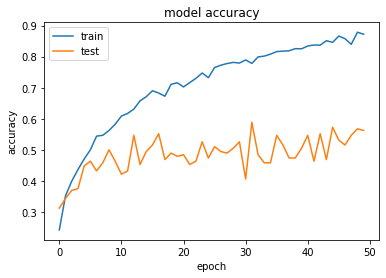

In [117]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['categorical_accuracy'])
plt.plot(cnnhistory.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

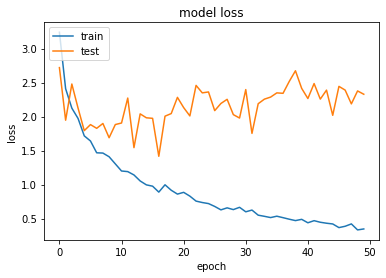

In [118]:
# Plotting the Train Valid Loss Graph

plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Load Model and Check on Test Data

In [119]:
import json
model_json = model.to_json()
with open("E:/NYU_Classes/Project/References/emotion_recognition_cnn/model/Modelfull_2_1.json", "w") as json_file:
    json_file.write(model_json)

In [120]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('E:/NYU_Classes/Project/References/emotion_recognition_cnn/model/Modelfull_2_1.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("E:/NYU_Classes/Project/References/emotion_recognition_cnn/model/Modelfull_2_1.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
categorical_accuracy: 58.85%


In [122]:
score

[1.7529756625493367, 0.5885416865348816]

In [127]:
test_db = dataset_db[(dataset_db.split=='Test')]
test_db.index = range(len(test_db.index))
test_db.shape

(192, 7)

In [128]:
test_db.head()

path   source actor gender  \
0  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess    23   male   
1  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess    23   male   
2  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess    23   male   
3  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess    23   male   
4  E:/NYU_Classes/Project/Ravdess_Audio_Speech_Ac...  Ravdess    23   male   

  emotion    emotion_lb split  
0       1  male_neutral  Test  
1       1  male_neutral  Test  
2       1  male_neutral  Test  
3       1  male_neutral  Test  
4       1  male_neutral  Test

In [129]:
test_audios= np.empty(shape=(test_db.shape[0],128, MFCC.shape[1], 1))

count=0
for i in tqdm(range(len(test_db))):
    signal, sample_rate = librosa.load(test_db.path[i], res_type='kaiser_fast',sr=22050*2)
    signal,index = librosa.effects.trim(signal,top_db = 25)
    signal = scipy.signal.wiener(signal)
    
    if len(signal) > input_length:
        signal = signal[0:input_length]
    elif  input_length > len(signal):
        max_offset = input_length - len(signal)  
        signal = np.pad(signal, (0, max_offset), "constant")

    melspec = librosa.feature.melspectrogram(signal, sr=sample_rate, n_mels=128,n_fft=2048,hop_length=512)   
    logspec = librosa.amplitude_to_db(melspec)
    logspec = np.expand_dims(logspec, axis=-1)
    test_audios[count,] = logspec 
    count+=1

In [130]:
test_audios.shape

(192, 128, 259, 1)

In [131]:
model_preds = loaded_model.predict(test_audios,batch_size=16,verbose=1)

192/192 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 5ms/step


In [133]:
preds_class=model_preds.argmax(axis=1);preds_class

array([ 9,  9,  7,  9, 10, 10, 10, 10, 10, 10, 10, 10,  9,  9,  9,  9,  9,
        9,  9,  9, 10, 10, 10, 10,  7, 10,  7, 10,  9,  9,  9,  9,  6,  9,
        9,  9,  9, 10,  9,  9,  9,  3,  9,  9,  7,  9,  7,  7,  7,  7,  7,
        9,  5,  5,  4,  4,  4,  4,  4,  4,  1,  4,  4,  4,  5,  4,  4,  5,
        1,  3,  2,  5,  4,  4,  4,  4,  1,  2,  4,  1,  0,  0,  5,  0,  0,
        0,  1,  1,  2,  2,  2,  1,  3,  5,  2,  2,  1,  1,  1,  1,  1,  1,
        1,  1, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9, 10,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10,  9,  8,  9,  9,
        6,  6,  9,  6, 10, 10, 11, 11,  8,  8,  8,  9,  4,  5,  4,  4,  4,
        4,  5,  4,  5,  4,  4,  4,  4,  4,  2,  4,  2,  3,  4,  2,  5,  5,
        5,  5,  4,  4,  5,  4,  0,  0,  0,  2,  0,  0,  0,  0,  2,  5,  2,
        2,  0,  2,  2,  0], dtype=int64)

In [138]:
preds_class = preds_class.astype(int).flatten()

In [139]:
predictions = (lb.inverse_transform((preds_class)))

In [142]:
Prediction_DF = pd.DataFrame({'predictedvalues': predictions})
Prediction_DF[0:10]

predictedvalues
0      male_happy
1      male_happy
2    male_disgust
3      male_happy
4    male_neutral
5    male_neutral
6    male_neutral
7    male_neutral
8    male_neutral
9    male_neutral

In [151]:
Actual_DF = pd.DataFrame({'actualvalues': test_db.emotion_lb})
Actual_DF[0:10]

actualvalues
0  male_neutral
1  male_neutral
2  male_neutral
3  male_neutral
4  male_neutral
5  male_neutral
6  male_neutral
7  male_neutral
8  male_neutral
9  male_neutral

In [155]:
finaldf = pd.concat([Actual_DF,Prediction_DF],axis=1)
finaldf

actualvalues predictedvalues
0      male_neutral      male_happy
1      male_neutral      male_happy
2      male_neutral    male_disgust
3      male_neutral      male_happy
4      male_neutral    male_neutral
..              ...             ...
187  female_fearful  female_fearful
188  female_fearful    female_angry
189  female_fearful  female_fearful
190  female_fearful  female_fearful
191  female_fearful    female_angry

[192 rows x 2 columns]

In [156]:
finaldf.groupby('actualvalues').count()

predictedvalues
actualvalues                   
female_angry                 16
female_disgust                8
female_fearful               16
female_happy                 16
female_neutral               24
female_sad                   16
male_angry                   16
male_disgust                  8
male_fearful                 16
male_happy                   16
male_neutral                 24
male_sad                     16

In [157]:
finaldf.groupby('predictedvalues').count()

actualvalues
predictedvalues              
female_angry               14
female_disgust             15
female_fearful             16
female_happy                4
female_neutral             32
female_sad                 16
male_angry                  4
male_disgust                9
male_fearful                4
male_happy                 38
male_neutral               38
male_sad                    2

In [158]:
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

53.645833333333336

In [159]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

49.021737629912494

In [161]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(y_true, y_pred)
c_matrix

array([[12,  2,  1,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 2,  1, 10,  1,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  4,  2,  6,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 18,  5,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  1,  0,  8,  5,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  4,  0,  1, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  0,  2,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  3,  7,  3,  2],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 15,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  3, 20,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  2,  0,  0, 14,  0]], dtype=int64)

In [162]:
class_names = sorted(set(finaldf.actualvalues))

Text(0.5, 26.359375, 'Predicted label')

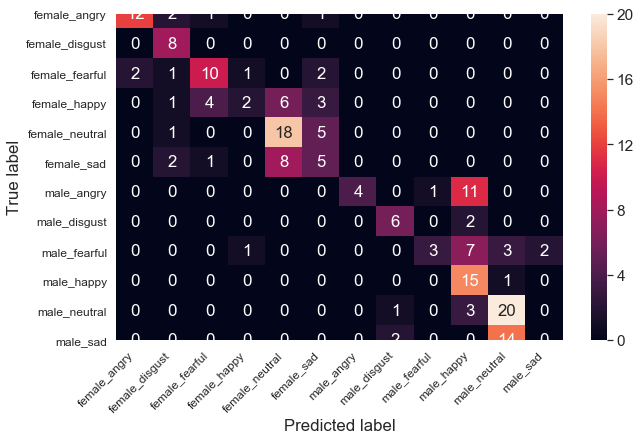

In [178]:
df_cm = pd.DataFrame(c_matrix, index=class_names, columns=class_names)

plt.figure(figsize=(10,6))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")


heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
plt.ylabel('True label')
plt.xlabel('Predicted label')